# Test Autoencoder

Examples taken from: 

https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/

https://blog.keras.io/building-autoencoders-in-keras.html


Read also (TODO):

https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial

https://github.com/snatch59/keras-autoencoders

VAE:
http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/

## Setup

In [1]:
from IPython.display import Image, SVG
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

import seaborn as sns

from random import randint
from scipy import stats
from sklearn.utils import shuffle
from sklearn.neighbors import NearestNeighbors

import pandas as pd
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from keras import regularizers

/home/donini/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2D plots

In [2]:
def TwoDplot(x_benchmark,x_trial,index0,index1):
        """
        standalone plots of benchmark/trial samples in 2D feature space
        """
        sns.set_style('whitegrid')
        
        fig, ax = plt.subplots()
        cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
        
        plt.title('Benchmark and Trial Samples', fontsize=16)
        
        ax.xaxis.set_tick_params(labelsize=16, direction='inout', length=6, width=1, color='gray')
        ax.yaxis.set_tick_params(labelsize=16, direction='inout', length=6, width=1, color='gray')
        
        ax.scatter(x_benchmark[:,index0], x_benchmark[:,index1], c='magenta',
                   alpha=0.5, marker='x',label='Train')
        ax.scatter(x_trial[:,index0],x_trial[:,index1], c='blue',
                   alpha=0.2, marker='s',label='Test')
                   
        plt.grid(True)
        plt.legend(loc='upper left', fontsize=14)
        plt.show()

## Get Data

In [3]:
# Test with dijet data (Test3)

# Get data
#---------
signal_all = pd.read_csv('signal_Full_Test3.txt',delimiter=' ',index_col=False)
background_all = pd.read_csv('background_Full_Test3.txt',delimiter=' ',index_col=False)


## Coordinate transformations

In [4]:

# (px,py,pz,E) -> (pt, eta, phi, E) où:
# pt = sqrt(px² + py²)
# eta = - ln ( tan (theta/2) ), avec theta = atan2 (pt, pz)
# phi = atan2(py, px)

def ptetaphi(df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'pt1','py1':'eta1','pz1':'phi1','px2':'pt2','py2':'eta2','pz2':'phi2'}, inplace=True)

    
ptetaphi(signal_all)
ptetaphi(background_all)



## Construct x_train and x_test samples (BG + frac signal)

In [5]:
# choose data features
#---------------------
#signal_sel = signal_all.loc[:,['M12','S']]
#background_sel = background_all.loc[:,['M12','S']]

signal_sel = signal_all.iloc[:,0:13]
background_sel = background_all.iloc[:,0:13]

# optional: drop columns
#signal_sel = signal_sel.drop(columns=['phi1','phi2'])
#background_sel = background_sel.drop(columns=['phi1','phi2'])


# Construct x_train and x_test samples (BG + frac signal)
#-------------------------------------------------------------
back = shuffle(background_sel.values)
sig  = shuffle(signal_sel.values)

varname = list(signal_sel)

N = 20000
signal_frac = 1.00
Nsignal = int(N*signal_frac)
x_train = back[0:N]
background = back[N+1:N+1+N-Nsignal]
signal = sig[0:Nsignal]
x_test = np.concatenate((background,signal))
print('bg all=', background_all.shape, 'sig all=', signal_all.shape, 'sig frac=', signal.shape, 'bg=', background.shape, 'x_test=', x_test.shape)


bg all= (54194, 13) sig all= (52766, 13) sig frac= (20000, 13) bg= (0, 13) x_test= (20000, 13)


### Look at data

Original Images


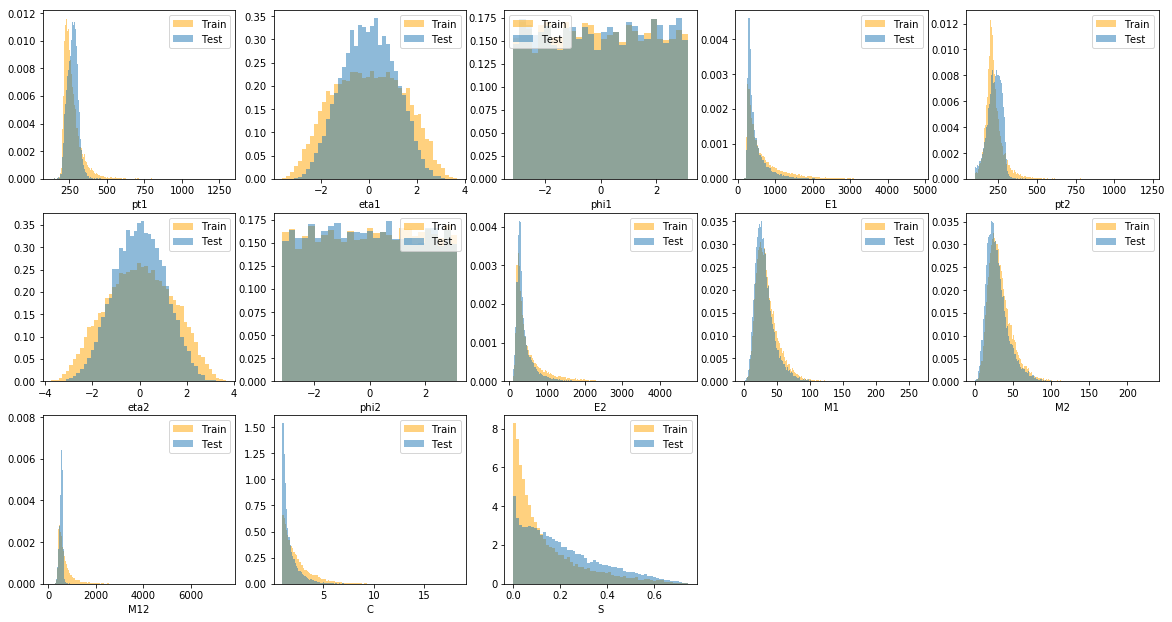

In [6]:
# plots

"""
print("2D plots")
plt.figure(figsize=(15, 15))
for i in range(x_test.shape[1]):
    for j in range(x_test.shape[1]):
        if (j>i): TwoDplot(x_train,x_test,i,j)
"""

print("Original Images")
plt.figure(figsize=(20, 18))
for i in range(x_test.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(x_train[:,i], bins='auto', color = 'orange', alpha=0.5, label='Train', normed=1)
    plt.hist(x_test[:,i], bins, alpha=0.5, label='Test', normed=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
plt.savefig('images/Original_variables.png')


## Rescale data

In [7]:
# Rescale data
#-------------
scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = Normalizer()

# fit (get min and max) and transform x_train
x_train = scaler.fit_transform(x_train)

# transform x_test (using scale parameters of x_train)
x_test = scaler.transform(x_test)

print('Trial sample size: ',x_test.shape)
print('Benchmark sample size: ',x_train.shape)

Trial sample size:  (20000, 13)
Benchmark sample size:  (20000, 13)


## Partition training data

In [8]:
# After all of this, it's important to partition the data. In order for your model to generalize well, 
# you split the training data into two parts: a training and a validation set. 
# You will train your model on 80% of the data and validate it on 20% of the remaining training data. 

from sklearn.model_selection import train_test_split

x_train_train,x_train_valid = train_test_split(x_train,test_size=0.2,random_state=13) 
print(x_train_train.shape)
print(x_train_valid.shape)

(16000, 13)
(4000, 13)


# Simple AutoEncoder

In [9]:
### See: https://ramhiser.com/post/2018-05-14-autoencoders-with-keras/

# Setup AE
# The autoencoder model maps an input image to its reconstructed image.

input_dim = x_train.shape[1]
encoding_dim = 5

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()

autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='selu')
)
autoencoder.add(
    Dense(input_dim, activation='sigmoid')
)

autoencoder.summary()

# Encoder Model (i.e image in latent space)
# We can extract the encoder model from the first layer of the autoencoder model. 
# The reason we’d want to do this is to examine what an encoded image looks like.

input_img = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]

encoder = Model(input_img, encoder_layer(input_img))

encoder.summary()

Compression factor: 2.6
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 70        
_________________________________________________________________
dense_2 (Dense)              (None, 13)                78        
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 70        
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


# Deep Autoencoder

## Train AE

In [10]:
# Recording loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()


# Train AE
epochs=50

# See example of loss functions here:
# https://github.com/keras-team/keras/blob/master/keras/losses.py

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_train = autoencoder.fit(x_train_train, x_train_train,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_train_valid, x_train_valid),
                callbacks=[history])

# Print history
print(history.losses)


Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 0s 12us/step - loss: 0.0802 - val_loss: 0.0612
Epoch 2/50
16000/16000 [==============================] - 0s 4us/step - loss: 0.0486 - val_loss: 0.0378
Epoch 3/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0321 - val_loss: 0.0275
Epoch 4/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0254 - val_loss: 0.0235
Epoch 5/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0225 - val_loss: 0.0214
Epoch 6/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0208 - val_loss: 0.0200
Epoch 7/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0195 - val_loss: 0.0187
Epoch 8/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0183 - val_loss: 0.0176
Epoch 9/50
16000/16000 [==============================] - 0s 3us/step - loss: 0.0173 - val_loss: 0.0167
Epoch 10/50
16

## Training vs Validation Loss Plot

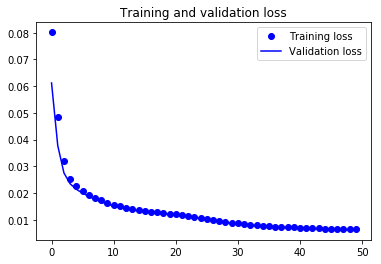

In [11]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


## Predicting on test data

In [12]:
# Apply AE 

# on test data
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

# on train data
encoded_imgs_train = encoder.predict(x_train)
decoded_imgs_train = autoencoder.predict(x_train)

#print("compressed data: ", encoded_imgs.shape)
print("AE output: ", decoded_imgs.shape)

AE output:  (20000, 13)


## Calculate figure of merit

Calculate L2 norm of train and test samples


20000 20000


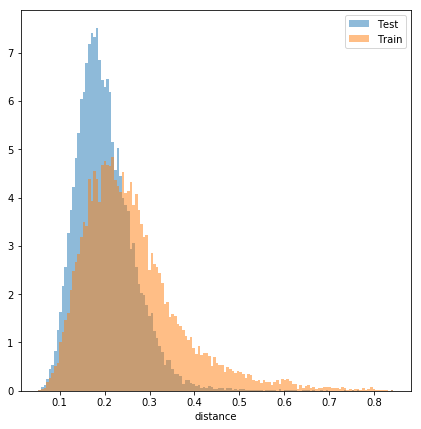

In [13]:
# Calculate L2 norm of train and test samples
# norm = |x_in - x_out|^2

from numpy.linalg import norm

norm_test=[]
for i in range(x_test.shape[0]):
    norm_test += [norm(x_test[i,:]-decoded_imgs[i,:])]

norm_train=[]
for i in range(x_train.shape[0]):
    norm_train += [norm(x_train[i,:]-decoded_imgs_train[i,:])]

    
print(len(norm_test), len(norm_train))

#bins = np.arange(0, 1, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_test, bins='auto', alpha=0.5, label='Test', normed=1)
plt.hist(norm_train, bins, alpha=0.5, label='Train', normed=1)
plt.xlabel('distance')
plt.legend(loc='upper right')
plt.savefig("images/distances.png")


## ROC Curve

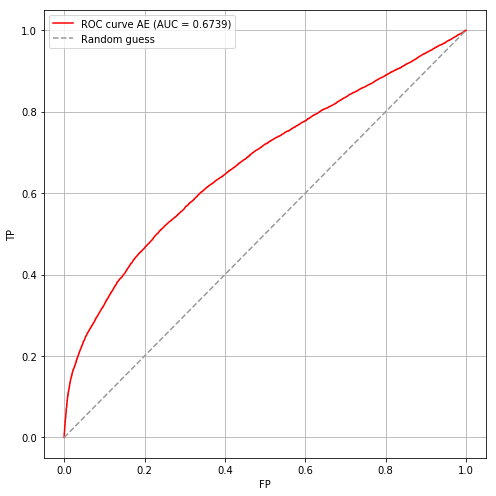

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

target = np.concatenate((np.zeros(x_train.shape[0]),np.ones(x_test.shape[0])))

scores = np.concatenate((norm_train,norm_test))  

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores,pos_label=0)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/ROC.png")

Train variables: true and reco


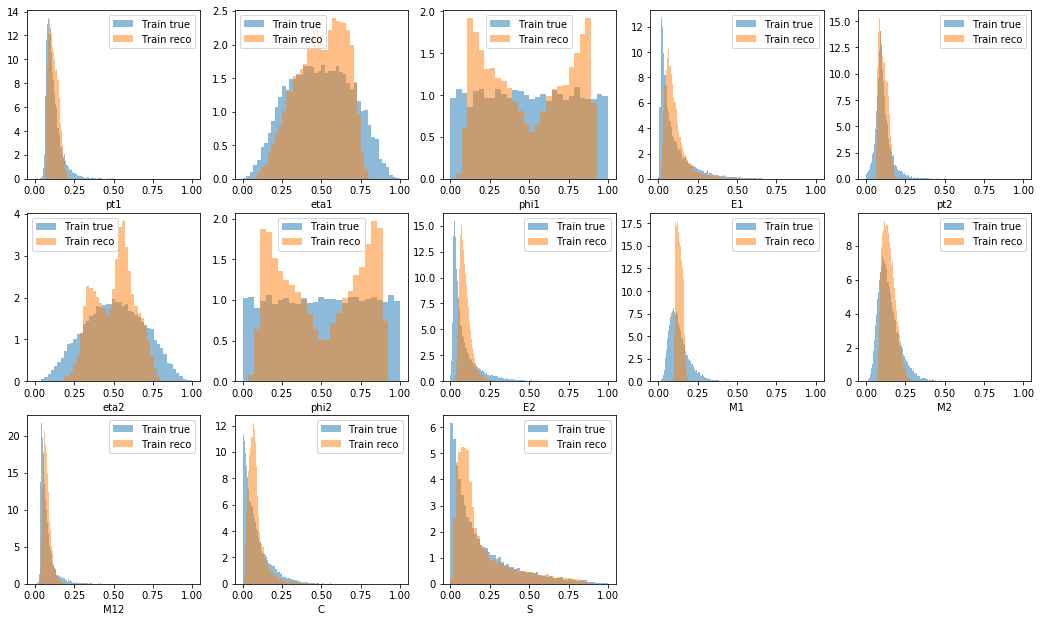

In [15]:
#bins = np.arange(0, 1, 0.01)

print("Train variables: true and reco")
plt.figure(figsize=(18, 18))
for i in range(x_test.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(x_train[:,i], bins='auto', alpha=0.5, label='Train true', normed=1)
    n, bins, patches = plt.hist(decoded_imgs_train[:,i], bins, alpha=0.5, label='Train reco', normed=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
plt.savefig('images/train_variables_true_reco.png')


Test variables: true and reco


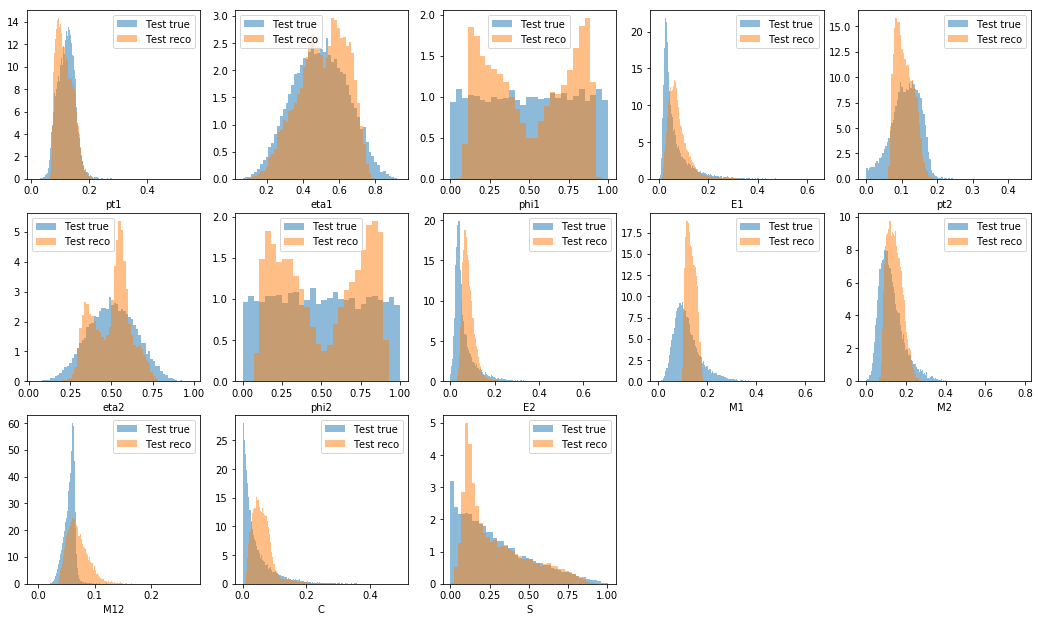

In [16]:
print("Test variables: true and reco")
plt.figure(figsize=(18, 18))
for i in range(x_test.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(x_test[:,i], bins='auto', alpha=0.5, label='Test true', normed=1)
    n, bins, patches = plt.hist(decoded_imgs[:,i], bins, alpha=0.5, label='Test reco', normed=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')
    
plt.savefig('images/test_variables_true_reco.png')


Train variables: scatter plot


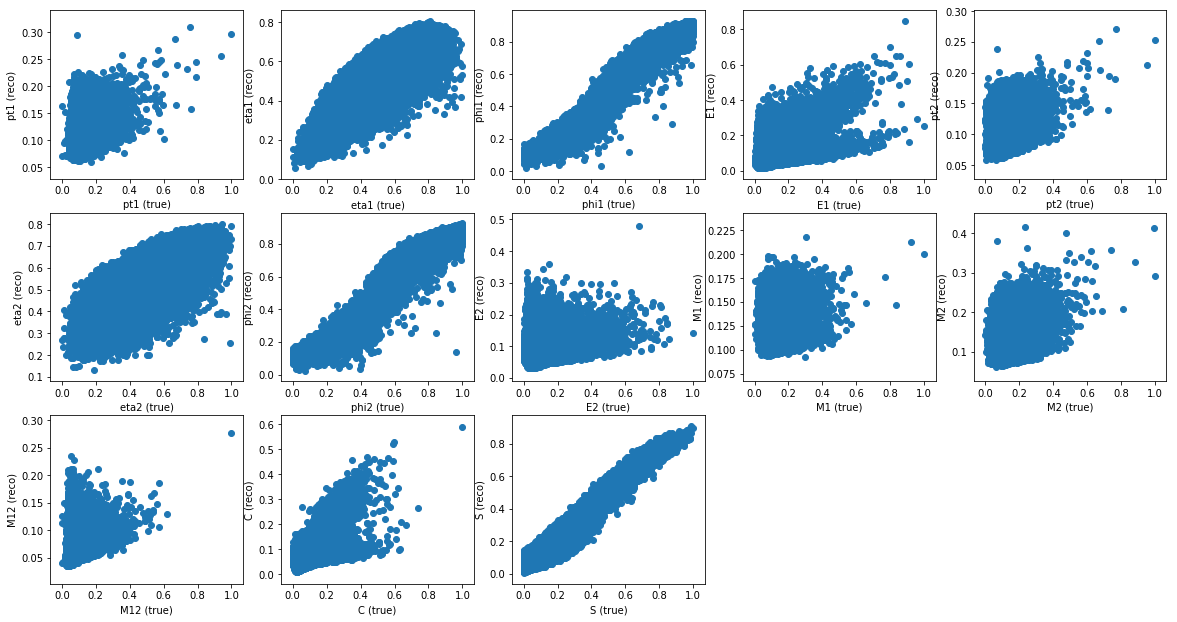

In [17]:
print("Train variables: scatter plot")
plt.figure(figsize=(20, 18))
for i in range(x_test.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.scatter(x_train[:,i], decoded_imgs_train[:,i])
    plt.xlabel(varname[i]+' (true)')
    plt.ylabel(varname[i]+' (reco)')
    
plt.savefig('images/train_variables_true_reco_scatter.png')
